In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset as TData
from torch.utils.data import DataLoader as DL

In [2]:
def bandpass_filter(signal, crit_freq = [1, 40], sampling_freq = 128, plot = False, channel = 0):
  order = 4

  b, a = scipy.signal.butter(2, crit_freq, btype = 'bandpass', fs = sampling_freq)
  processed_signal = scipy.signal.filtfilt(b, a, signal, 1)

  if plot == True:
    plt.figure()
    plt.xlabel('Time')
    plt.ylabel(f'Normalized amplitude of channel {channel}')
    plt.title(f'{crit_freq[0]}-{crit_freq[1]}Hz bandpass filter')
    signal_min = np.full((signal.shape[1], signal.shape[0]), np.min(signal, 1)).transpose()
    signal_max = np.full((signal.shape[1], signal.shape[0]), np.max(signal, 1)).transpose()
    normed_signal = (signal - signal_min) / (signal_max - signal_min)
    filtered_min = np.full((processed_signal.shape[1], processed_signal.shape[0]), np.min(processed_signal, 1)).transpose()
    filtered_max = np.full((processed_signal.shape[1], processed_signal.shape[0]), np.max(processed_signal, 1)).transpose()
    normed_filt = (processed_signal - filtered_min) / (filtered_max - filtered_min)
    plt.plot(np.arange(normed_signal[channel].size), normed_signal[channel], label = 'Input')
    plt.plot(np.arange(normed_filt[channel].size), normed_filt[channel], label = 'Transformed')
    plt.legend()

  return processed_signal

In [3]:
def segmentation(signal, sampling_freq=128, window_size=1, window_shift=0.016):
  w_size = int(sampling_freq * window_size)
  w_shift = int(sampling_freq * window_shift)
  segments = []
  i = 0
  while i + w_size <= signal.shape[1]:
    segments.append(signal[:, i: i + w_size])
    i += w_shift
  return segments

In [7]:
new_base = "/Users/ajfor/Documents/data_nathan_LR"
#print(os.pwd())
files = os.listdir(new_base)
paths = [os.path.join(new_base, file) for file in files]

file_splits = [file.rstrip('.npy').split('_')[3] for file in files]
sessions = map(int, set(file_splits))
sorted_sessions = sorted(list(sessions))[8:] 
sorted_sessions.remove(31)
sorted_sessions.remove(34)
sorted_sessions.remove(41)
sorted_sessions.remove(14)
sorted_sessions.remove(18)
sorted_sessions.remove(11)
sorted_sessions.remove(28)
sorted_sessions.remove(26)
sorted_sessions.remove(32)
sorted_sessions.remove(21)
print(sorted_sessions) # 17 sessions in total

[9, 10, 12, 13, 15, 16, 17, 19, 20, 22, 23, 24, 25, 27, 29, 30, 33, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [8]:
def channel_rearrangment(sig, channel_order):
    channel_order = [channel - 1 for channel in channel_order]
    reindexed = np.zeros_like(sig)
    for i, ind in enumerate(channel_order):
        reindexed[i] = sig[ind]
    return reindexed

ordered_channels = [1, 9, 11, 3, 13, 5, 7, 15, 2, 10, 12, 4, 14, 6, 8, 16]

In [10]:
import itertools

class LimitedDataLoader:
    def __init__(self, dataloader, max_batches):
        self.dataloader = dataloader
        self.max_batches = max_batches

    def __iter__(self):
        return itertools.islice(self.dataloader, self.max_batches)

    def __len__(self):
        return min(len(self.dataloader), self.max_batches)

In [13]:
from tqdm import tqdm


def train_fusion_model(lin, train_dl, valid_dl, index):
  print(f'Training model {index}')
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(lin.parameters(), lr = 0.01, weight_decay=5e-3)
  epochs = 25

  train_losses = []
  val_losses = []
  accs = []
  max_acc = 0
  best_loss = 1000
  for i in range(epochs):
    total_train_loss = 0.0
    lin.train()
    pbar = tqdm(total=len(train_dl))
    for j, (sig, labels) in tqdm(enumerate(train_dl)):
      sig = sig.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      pred = lin(sig)
      loss = criterion(pred, labels)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

      pbar.set_description(f"Epoch {i + 1}    loss={total_train_loss / (j + 1):0.4f}")
      pbar.update(1)
      # if best loss is less than current loss, decrease learning rate
    if  total_train_loss / len(train_dl) > best_loss:
      for g in optimizer.param_groups:
        g['lr'] *= 0.9
    else:
      best_loss = total_train_loss / len(train_dl)
    pbar.close()
    train_losses.append(total_train_loss / len(train_dl))
    total_val_loss = 0.0
    total_accuracy = 0.0
    #count_val = 0
    lin.eval()
    with torch.no_grad():
        pbar = tqdm(total=len(valid_dl))
        for j, (sig, labels) in enumerate(valid_dl):
            # w_size = 128
            # ind = 0
            # hn = None
            # while ind + w_size < sig.shape[1]:
            #   signal = sig[:, :, ind: ind + w_size].to(device)
            #   #signal = signal.transpose(1, 2)
            #   labels = labels.to(device)
              
            #   pred = lin(signal)
              
            #   #pred = pred.reshape(-1, *pred.shape[2:]) 
            #   # pred = torch.argmax(pred, 2)
            #   # pred = torch.mode(pred, 1)[0]

            #   ind += 3
              #count_val += 1
            sig = sig.to(device)
            labels = labels.to(device)
            pred = lin(sig)
            loss = criterion(pred, labels)

            prob_pred = torch.nn.functional.softmax(pred, -1)
            acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
            total_val_loss += loss.item()
            total_accuracy += acc.item()

            # if (i + 1) % 5 == 0 and j == (len(valid_dl) - 1):
            #   print(f'val loss: {total_val_loss / (j + 1):.4f}    val accuracy: {total_accuracy / (j + 1):.4f}')
            pbar.set_description(f"val loss={total_val_loss / (j + 1):.4f}    val acc={total_accuracy / (j + 1):.4f}")
            pbar.update(1)
        print()
        pbar.close()
        val_losses.append(total_val_loss / len(valid_dl))
        accs.append(total_accuracy / len(valid_dl))
        
    # save model if val accuracy is less than val accuracy of previous epoch
    if accs[-1] > max_acc:
      ckpt = {'state_dict': lin.state_dict(), 'optimizer': optimizer.state_dict()}
      torch.save(ckpt, 'parallelConvLSTM2.pth.tar')
      print('model saved')
      max_acc = accs[-1]

  return {'index': index, 'train loss': train_losses, 'val_losses': val_losses, 'val accs': accs} # fuck you

In [14]:
class SpatialConv(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # convolutional block for spatial feature extraction
        self.block1 = torch.nn.Sequential(torch.nn.Conv1d(in_channels, 16, 64, padding = 'same', bias=False),
                                           torch.nn.BatchNorm1d(16), 
                                           torch.nn.ReLU(),
                                           torch.nn.Dropout(),
                                           torch.nn.AvgPool1d(2))
        self.flatten = torch.nn.Flatten()
        # separable convolutional block for additional feature extraction
        self.block2 = torch.nn.Sequential(torch.nn.Conv1d(16, 16, 16, padding = 'same', groups = 16, bias = False),
                                           torch.nn.Conv1d(16, 24, 1, padding = 'same', bias = False),
                                           torch.nn.BatchNorm1d(24),
                                           torch.nn.ReLU(),
                                           torch.nn.Dropout(),
                                           torch.nn.AvgPool1d(4))
        
    def forward(self, x):
        out = self.block1(x)
        y1 = self.flatten(out)
        y2 = self.flatten(self.block2(out))
        return y1, y2

class OrderedSpatialConv(torch.nn.Module):
    def __init__(self, groups, in_channels):
        super().__init__()
        self.groups = groups
        self.channels = in_channels
        self.block1 = torch.nn.Sequential(torch.nn.Conv2d(groups, 16, (3, 64), padding='same', groups = self.groups, bias = False), # return to 3, 16
                                          torch.nn.BatchNorm2d(16), 
                                          torch.nn.ReLU(),
                                          torch.nn.Dropout(),
                                          torch.nn.AvgPool2d((1, 2))) # return to 2
        self.flatten = torch.nn.Flatten()
        self.block2 = torch.nn.Sequential(torch.nn.Conv2d(16, 16, (3, 16), padding = 'same', groups = 16, bias = False), # return to 3, 16
                                           torch.nn.Conv2d(16, 24, 1, padding = 'same', bias = False),
                                           torch.nn.BatchNorm2d(24),
                                           torch.nn.ReLU(),
                                           torch.nn.Dropout(),
                                           torch.nn.AvgPool2d((2, 4)))
                                        #    torch.nn.Conv2d(24, 24, (2, 1)),
                                        #    torch.nn.ReLU(),
                                        #    torch.nn.Dropout())
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, self.groups, int(self.channels / self.groups), -1)
        out = self.block1(x)
        y1 = self.flatten(out)
        y2 = self.flatten(self.block2(out))
        return y1, y2
        

class LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=50, n_cells=3):
        super().__init__()
        self.lstm = torch.nn.LSTM(in_channels, hidden_channels, n_cells, batch_first=True, dropout = 0.4)
        self.flatten = torch.nn.Flatten()

    def forward(self, x, h0 = None):
        y, _ = self.lstm(x, h0)
        y = self.flatten(y)
        return y

class FusionLinear(torch.nn.Module):
    def __init__(self, in_channels, num_classes=3):
        super().__init__()
        self.spatial_fe = OrderedSpatialConv(4, in_channels)
        self.temporal_fe = LSTM(in_channels)

        # pass dummy input through spatial and temporal feature extractors to determine output size
        dummy_x = torch.zeros(1, in_channels, 192)
        out1 = self.spatial_fe(dummy_x)
        #print(out1[0].shape)
        #print(out1[1].shape)
        out2 = self.temporal_fe(dummy_x.transpose(1, 2))
        #print(out2.shape)
        dummy_out = torch.hstack([*out1, out2])
        self.l1 = torch.nn.Linear(dummy_out.shape[1], 2)

    def forward(self, x):
        spatial_x = self.spatial_fe(x)
        temporal_x = self.temporal_fe(x.transpose(1, 2))
        linear_input = torch.hstack([*spatial_x, temporal_x])
        y = self.l1(linear_input)
        return y

In [15]:
def augmentation(signals, labels, n):
    # Convert signals and labels to numpy arrays once
    signals, labels = np.array(signals), np.array(labels)
    
    # Find the signals with specific labels
    signals_left, signals_right = signals[np.where(labels == 1)], signals[np.where(labels == 3)]
    
    # Initialize the arrays for augmented data

    augmented, augmented_labels = np.empty((n, signals.shape[1], signals.shape[2]), dtype=signals.dtype), np.empty(n, dtype=labels.dtype)
    
    # Pre-generate indices for random choices
    left_indices, right_indices, random_uniforms, signal_indices = np.random.choice(len(signals_left), n), np.random.choice(len(signals_right), n), np.random.rand(n), np.random.choice(len(signals), n)

    for i in range(n):
        sig1_index = signal_indices[i]
        sig1 = signals[sig1_index]
        
        if sig1_index in np.where(labels == 1)[0]:
            sig2 = signals_right[right_indices[i]]
            augmented_labels[i] = 1
        else:
            sig2 = signals_left[left_indices[i]]
            augmented_labels[i] = 3
        
        index = int(random_uniforms[i] * sig1.shape[1])
        
        # Use pre-allocated array for augmented signal
        augmented[i, :, :index] = sig1[:, :index]
        augmented[i, :, index:] = sig2[:, index:]


    del signals_left
    del signals_right
    del random_uniforms
    del signal_indices
    
    return augmented, augmented_labels

In [16]:
%load_ext cython

In [17]:
%%cython
cimport numpy as np
from libc.math cimport exp

def swap_components(list dec1, list dec2, np.ndarray[np.int32_t, ndim=1] swap_flags):
    cdef int j
    cdef np.ndarray tmp
    for j in range(1, 4):
        if swap_flags[j-1]:
            tmp = dec1[j]
            dec1[j] = dec2[j]
            dec2[j] = tmp
    return dec1, dec2

Content of stderr:
In file included from /Users/ajfor/.cache/ipython/cython/_cython_magic_2573c8490a9cabad665efb560a8d200dd36bdbdf.c:1250:
In file included from /opt/miniconda3/envs/LHNT/lib/python3.12/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /opt/miniconda3/envs/LHNT/lib/python3.12/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/miniconda3/envs/LHNT/lib/python3.12/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/opt/miniconda3/envs/LHNT/lib/python3.12/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.

In [19]:
import pywt
import numpy as np

def wavelet_augmentation(signals, labels, n):
    signals, labels = np.array(signals), np.array(labels)
    signals_left, signals_right = signals[labels == 1], signals[labels == 3]
    augmented = np.empty((n, signals.shape[1], signals.shape[2]), dtype=signals.dtype)
    augmented_labels = np.empty(n, dtype=labels.dtype)

    left_indices = np.random.choice(len(signals_left), n)
    right_indices = np.random.choice(len(signals_right), n)

    # Adjust the number of augmentations per iteration
    n_half = n // 2

    # Pre-generate random choices and random swaps
    signal_indices = np.random.choice(len(signals), n_half)
    swap_flags = np.random.rand(n_half, 3) < 0.5

    left_membership = np.isin(np.arange(len(signals)), np.where(labels == 1)) # calculating this reduces time by 130%

    for i in range(n_half):
        sig1_index = signal_indices[i]
        sig1 = signals[sig1_index]
        if left_membership[sig1_index]:
            sig2 = signals_right[right_indices[i]]
            augmented_labels[i*2] = 1
            augmented_labels[i*2 + 1] = 3
        else:
            sig2 = signals_left[left_indices[i]]
            augmented_labels[i*2] = 3
            augmented_labels[i*2 + 1] = 1
        dec1 = pywt.wavedec(sig1, 'db4', level=3)
        dec2 = pywt.wavedec(sig2, 'db4', level=3)

        # much slower in pure python/numpy
        dec1, dec2 = swap_components(dec1, dec2, swap_flags[i].astype(np.int32))

        augmented[i*2] = pywt.waverec(dec1, 'db4')
        augmented[i*2 + 1] = pywt.waverec(dec2, 'db4')

    return augmented, augmented_labels


In [20]:
from efficientCapsnetPytorch.model.losses import TotalLoss, MarginLoss
from torch import optim
import matplotlib.pyplot as plt


def train_caps(train_loader, test_loader, index):
    model = EEGCapsNet(input_size=(1, 16, 192), num_classes=2)
    model.cuda()
    criterion = TotalLoss(recon_factor=0.0005)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    deep_super_weights = [1/(1.5**i) for i in range(4)]
    deep_super_weights = deep_super_weights / np.sum(deep_super_weights)

    train_losses = []
    val_losses = []
    accs = []
    max_acc = 0
    best_loss = 1000
    
    for i in range(35):
        total_loss = 0
        pbar = tqdm(total=len(train_loader))
        model.train()
        for j, (x, y) in enumerate(train_loader):
            x = x.float().cuda()
            y = y.cuda()
            x = x.unsqueeze(1)
            optimizer.zero_grad()
            outs = model(x)
            y = y.squeeze(1)
            full_loss = 0
            x_fft = torch.fft.fft(x, dim=-1)
            for k in range(0, 8, 2):
                loss = criterion(x_fft, y, outs[k+1], outs[k])
                loss *= deep_super_weights[k // 2]
                full_loss += loss
                loss.backward(retain_graph=True)

            optimizer.step()
            total_loss += full_loss.item()
            pbar.set_description(f"Epoch {i + 1}    loss={total_loss / (j + 1):0.4f}")
            pbar.update(1)
        
        if  total_loss / len(train_loader) > best_loss:
            for g in optimizer.param_groups:
                g['lr'] *= 0.9
            else:
                best_loss = total_loss / len(train_loader)
        pbar.close()
        train_losses.append(total_loss / len(train_loader))
        test_loss = 0
        total_accuracy = 0
        model.eval()
            
        test_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            pbar = tqdm(total=len(test_loader))
            for j, (x, y) in enumerate(test_loader):
                x = x.float().cuda()
                y = y.cuda()
                x = x.unsqueeze(1)
                outs = model(x, mode='eval')
                pred = outs[0]
                img = outs[1]
                y = y.squeeze(1)
                x_fft = torch.fft.fft(x, dim=-1)
                loss = criterion(x_fft, y, img, pred)
                test_loss += loss.item()
                predicted = torch.argmax(pred, -1)
                labels = torch.argmax(y, -1)
                accuracy = (predicted == labels).float().mean().item()
                total_accuracy += accuracy
                pbar.set_description(f"val loss={test_loss / (j + 1):0.4f}    val acc={total_accuracy / (j + 1):0.4f}")
                pbar.update(1)
            print()
            pbar.close()
            val_losses.append(test_loss / len(test_loader))
            accs.append(total_accuracy / len(test_loader))
            x = torch.abs(torch.fft.ifft(x, dim=-1))
            img = torch.abs(torch.fft.ifft(img, dim=-1))
            plt.plot(x[0, 0, 3, :100].cpu().numpy(), label='input')
            plt.plot(img[0, 0, 3, :100].cpu().numpy(), label='reconstruction')
            # mu and beta bands
            plt.axvline(8, color='r')
            plt.axvline(30, color='r')
            plt.legend()
            plt.show()
    
    return {'index': index, 'train loss': train_losses, 'val_losses': val_losses, 'val accs': accs}


ModuleNotFoundError: No module named 'efficientCapsnetPytorch'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Squash(nn.Module):
    def __init__(self, eps=1e-20):
        super(Squash, self).__init__()
        self.eps = eps

    def forward(self, x):
        norm = torch.linalg.norm(x, ord=2, dim=-1, keepdim=True)
        coef = 1 - 1 / (torch.exp(norm) + self.eps)
        unit = x / (norm + self.eps)
        return coef * unit

class Routing(nn.Module):
    def __init__(self, groups, in_dims, out_dims):
        super(Routing, self).__init__()
        N0, D0 = in_dims
        N1, self.D1 = out_dims
        self.W = nn.Parameter(torch.Tensor(groups, N1, N0, D0, self.D1))
        nn.init.kaiming_normal_(self.W)
        self.b = nn.Parameter(torch.zeros(groups, N1, N0, 1))
        self.squash = Squash()

    def forward(self, x):

        u = torch.einsum('...gni,gknid->...gknd', x, self.W) # shape: (B, G, N1, N0, D1)

        c = torch.einsum("...ij,...kj->...i", u, u) # shape: (B, N1, N0)

        c = c[..., None]  # (B, N1, N0, 1) for bias broadcasting
        c = c / torch.sqrt(torch.tensor(self.D1).float())  # stabilize
        c = torch.softmax(c, axis=1) + self.b

        ## new capsules
        s = torch.sum(u * c, dim=-2)

        return self.squash(s)
    

class ReconstructionNet(nn.Module):
    def __init__(self, input_size=(1, 28, 28), num_classes=2, num_capsules=64):
        super(ReconstructionNet, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(in_features=num_capsules * num_classes, out_features=512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, np.prod(input_size) * 2)
        self.elu = nn.ReLU()
        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc1.weight, gain=gain)
        nn.init.xavier_normal_(self.fc2.weight, gain=gain)
        nn.init.xavier_normal_(self.fc3.weight, gain=gain)

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(x.size(0), 2, *self.input_size).squeeze(1)
        complex_x = torch.complex(x[:, 0], x[:, 1])
        return complex_x
    

class CapsMask(nn.Module):
    def __init__(self):
        super(CapsMask, self).__init__()

    def forward(self, x, y_true=None):
        if y_true is not None:  # training mode
            mask = y_true
        else:  # testing mode
            # convert list of maximum value's indices to one-hot tensor
            temp = torch.sqrt(torch.sum(x**2, dim=-1))
            mask = F.one_hot(torch.argmax(temp, dim=1), num_classes=temp.shape[1])
        
        masked = x * mask.unsqueeze(-1)

        return masked.view(x.shape[0], -1)  # reshape
    

class CapsLen(nn.Module):
    def __init__(self, eps=1e-7):
        super(CapsLen, self).__init__()
        self.eps = eps

    def forward(self, x):
        return torch.sqrt(
            torch.sum(x**2, dim=-1) + self.eps
        )  # (batch_size, num_capsules)


In [ ]:

class EEGCapsNet(nn.Module):
    def __init__(self, input_size=(1, 16, 192), num_classes=2):
        super(EEGCapsNet, self).__init__()
        self.channelCapsTemporal_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1,64), groups=16, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,input_size[2]-63), groups=128) # collapse to 1 point
        )
        self.channelCapsTemporal_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 24), groups=16, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,input_size[2]-23), groups=128) # collapse to 1 point
        )
        # channel caps will eventually be transformed from 8x4 capsules to 4x8 higher level capsules

        self.channelRouting = Routing(16, (8, 4), (4, 8))
        self.channelShrink = Routing(8, (8, 8), (4, 8))
        self.channelDeepSuper = Routing(1, (64, 8), (2, 32))

        self.localCapsSpatial_1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(2, 36), groups=8, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, input_size[2]-35), groups=64) # collapse to 1 point
        )
        
        self.localCapsSpatial_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(2, 16), groups=8),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, input_size[2]-15), groups=64) # collapse to 1 point
        )

        self.localRouting = Routing(8, (8, 4), (4, 8))
        self.localShrink = Routing(8, (8, 8), (4, 16))
        self.localRegion = Routing(4, (8, 16), (4, 16))
        self.localDeepSuper = Routing(1, (32, 8), (2, 64))

        # local spatial caps will be transformed from 8x4 capsules to 8x8 higher level capsules
        # local caps will be 16x8 (with addition from channel caps) this will be reduced to 8x8


        self.regionCapsSpatial_1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(4, 24), groups=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, input_size[2]-23), groups=32) # collapse to 1 point
        )

        self.regionCapsSpatial_2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(4, 32), groups=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, input_size[2]-31), groups=32) # collapse to 1 point
        )

        # region caps will be transformed from 8x4 capsules to 16x8 higher level capsules
        # region caps will be 32x8 (with addition from local caps) this will be reduced to 16x8

        self.regionRouting = Routing(4, (8, 4), (4, 16))
        self.regionShrink = Routing(4, (8, 16), (4, 16))
        self.regionHemi = Routing(2, (8, 16), (4, 16))
        self.regionDeepSuper = Routing(1, (16, 16), (2, 64))


        self.hemiCapsSpatial_1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(8, 30), groups=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, input_size[2]-29), groups=16) # collapse to 1 point
        )

        self.hemiCapsSpatial_2 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(8, 60), groups=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, input_size[2]-59), groups=16) # collapse to 1 point
        )

        # hemi caps will be transformed from 8x4 capsules to 32x8 higher level capsules
        # hemi caps will be 64x8 (with addition from region caps) this will be reduced to 32x8

        self.hemiRouting = Routing(2, (8, 4), (4, 16))
        self.hemiShrink = Routing(2, (8, 16), (4, 16))

        self.out = Routing(1, (8, 16), (num_classes, 64))
        self.generator = ReconstructionNet(input_size, num_classes)
        self.channel_generator = ReconstructionNet(input_size, num_classes, num_capsules=32)
        self.local_generator = ReconstructionNet(input_size, num_classes, num_capsules=64)
        self.region_generator = ReconstructionNet(input_size, num_classes, num_capsules=64)
        self.mask = CapsMask()
        self.capsLen = CapsLen()


    def forward(self, x, y_true=None, mode='train'):
        x = x.permute(0, 2, 1, 3)
        data = x
        x1 = self.channelCapsTemporal_1(data).view(data.size(0), 16, 16)
        x2 = self.channelCapsTemporal_2(data).view(data.size(0), 16, 16)
        channels = torch.cat((x1, x2), dim=2).view(data.size(0), 16, 8, 4)
        channels = self.channelRouting(channels)
        deep_channels = self.channelDeepSuper(channels.view(data.size(0), 1, 64, 8))
        new_locals = self.channelShrink(channels.view(data.size(0), 8, 8, 8))

        x1 = self.localCapsSpatial_1(data.view(data.size(0), 8, 2, 192)).view(data.size(0), 8, 16)
        x2 = self.localCapsSpatial_2(data.view(data.size(0), 8, 2, 192)).view(data.size(0), 8, 16)
        local = torch.cat((x1, x2), dim=2).view(data.size(0), 8, 8, 4)
        local = self.localRouting(local)
        deep_locals = self.localDeepSuper(local.view(data.size(0), 1, 32, 8))

        local = torch.cat((local, new_locals), dim=2)
        local = self.localShrink(local)
        new_regions = self.localRegion(local.view(data.size(0), 4, 8, 16))

        x1 = self.regionCapsSpatial_1(data.view(data.size(0), 4, 4, 192)).view(data.size(0), 4, 16)
        x2 = self.regionCapsSpatial_2(data.view(data.size(0), 4, 4, 192)).view(data.size(0), 4, 16)
        regions = torch.cat((x1, x2), dim=2).view(data.size(0), 4, 8, 4)
        regions = self.regionRouting(regions)
        deep_regions = self.regionDeepSuper(regions.view(data.size(0), 1, 16, 16))
        regions = torch.cat((regions, new_regions), dim=2)
        regions = self.regionShrink(regions)
        new_hemis = self.regionHemi(regions.view(data.size(0), 2, 8, 16))

        x1 = self.hemiCapsSpatial_1(data.view(data.size(0), 2, 8, 192)).view(data.size(0), 2, 16)
        x2 = self.hemiCapsSpatial_2(data.view(data.size(0), 2, 8, 192)).view(data.size(0), 2, 16)
        hemis = torch.cat((x1, x2), dim=2).view(data.size(0), 2, 8, 4)
        hemis = self.hemiRouting(hemis)
        hemis = torch.cat((hemis, new_hemis), dim=2)
        hemis = self.hemiShrink(hemis).view(data.size(0), 1, 8, 16)

        out = self.out(hemis)
        out = out.squeeze(1)

        pred = self.capsLen(out)

        if mode == "train":
            masked = self.mask(out, y_true)
            deep_channels = deep_channels.squeeze(1)
            deep_locals = deep_locals.squeeze(1)
            deep_regions = deep_regions.squeeze(1)
            masked_channels = self.mask(deep_channels, y_true)
            masked_locals = self.mask(deep_locals, y_true)
            masked_regions = self.mask(deep_regions, y_true)
        elif mode == "eval":
            masked = self.mask(out)
            x = self.generator(masked)
            return pred, x
        elif mode == "test":
            return pred
        x = self.generator(masked)
        x_channels = self.channel_generator(masked_channels)
        x_locals = self.local_generator(masked_locals)
        x_regions = self.region_generator(masked_regions)
        pred_channels = self.capsLen(deep_channels)
        pred_locals = self.capsLen(deep_locals)
        pred_regions = self.capsLen(deep_regions)

   
        return pred, x, pred_regions, x_regions, pred_locals, x_locals, pred_channels, x_channels

TRAIN: [ 9 10 12 13 15 16 17 19 20 22 23 24 25 27 29 30 33 35 36 37 38 39 40 42
 43 44 45 46 47 48 49 50 51 53 54 55 56 57] TEST: [52]
[52]


/tmp/ipykernel_1701368/3986792437.py:33: RuntimeWarning: invalid value encountered in divide
  filtered_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling


EEGMouse_Nathan_1_47_1173.npy
EEGMouse_Nathan_1_50_1240.npy
EEGMouse_Nathan_1_51_1262.npy
Creating augmented data
Data created


/home/nathan/miniconda3/envs/swinunetr2/lib/python3.9/site-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
val loss=0.2377    val acc=0.5246: 100%|██████████| 210/210 [00:01<00:00, 120.32it/s]


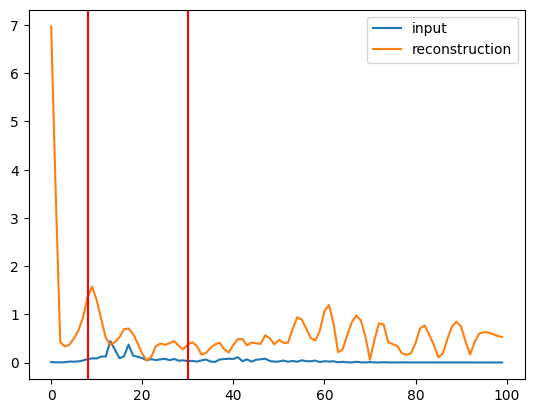

val loss=0.2216    val acc=0.6146: 100%|██████████| 210/210 [00:01<00:00, 120.09it/s]


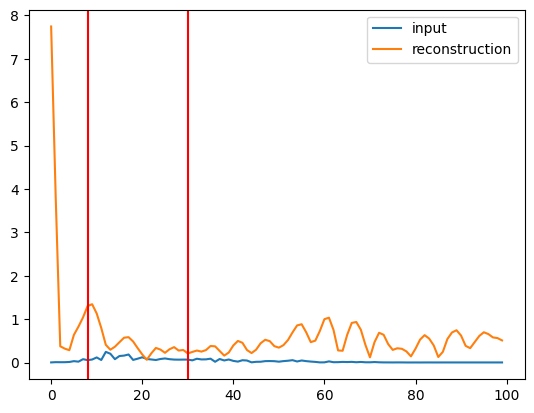

val loss=0.2222    val acc=0.6426: 100%|██████████| 210/210 [00:01<00:00, 118.57it/s]


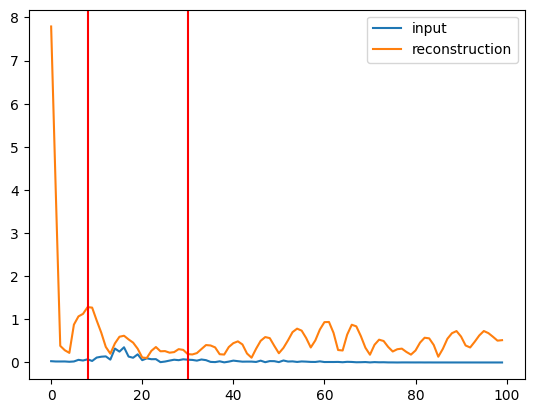

val loss=0.2257    val acc=0.6161: 100%|██████████| 210/210 [00:01<00:00, 120.14it/s]


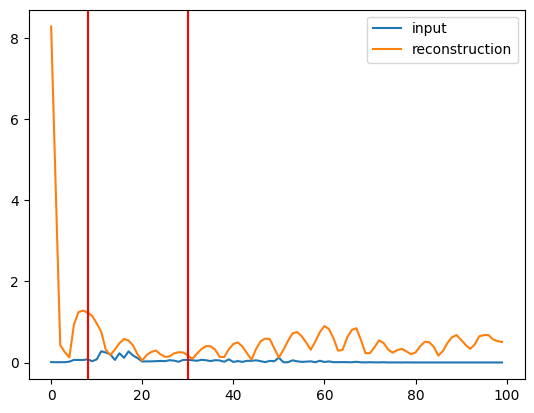

val loss=0.2081    val acc=0.6552: 100%|██████████| 210/210 [00:01<00:00, 120.20it/s]


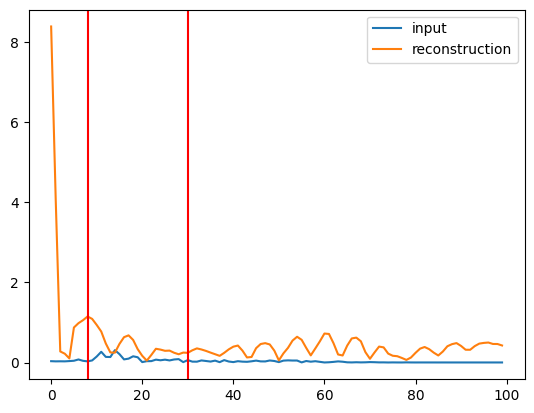

val loss=0.2038    val acc=0.6969: 100%|██████████| 210/210 [00:01<00:00, 118.68it/s]


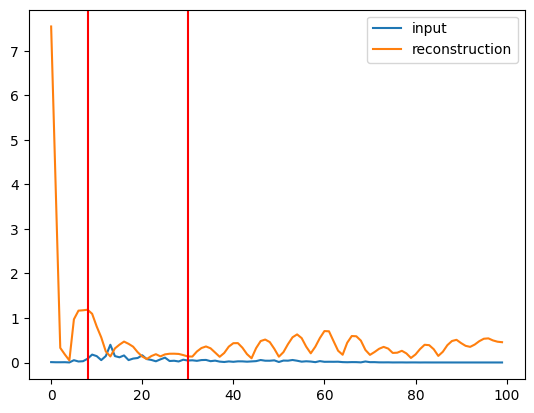

val loss=0.2107    val acc=0.6673: 100%|██████████| 210/210 [00:01<00:00, 119.68it/s]


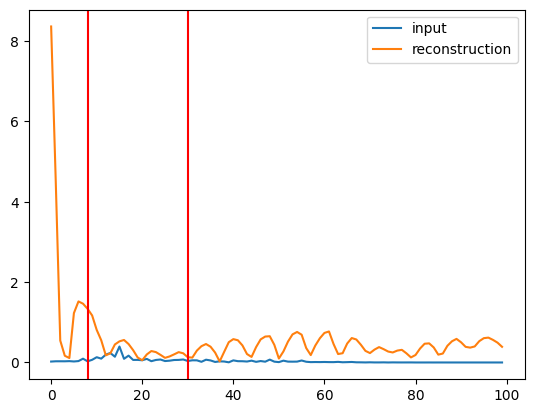

val loss=0.2050    val acc=0.6784: 100%|██████████| 210/210 [00:01<00:00, 113.57it/s]


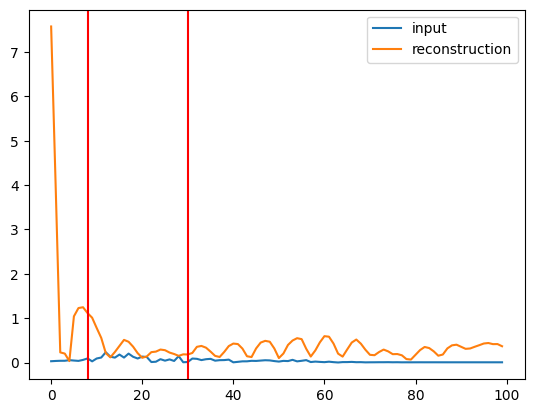

val loss=0.2211    val acc=0.6231: 100%|██████████| 210/210 [00:01<00:00, 119.73it/s]


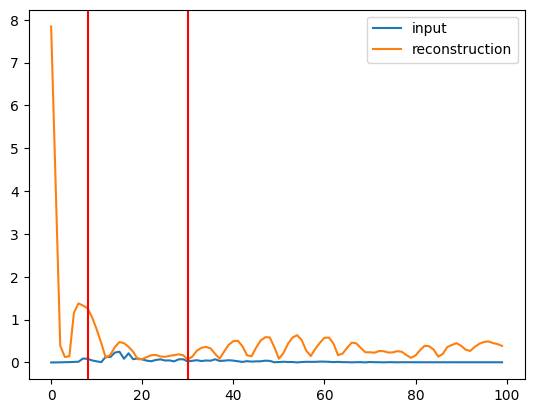

val loss=0.2151    val acc=0.6726: 100%|██████████| 210/210 [00:01<00:00, 121.98it/s]


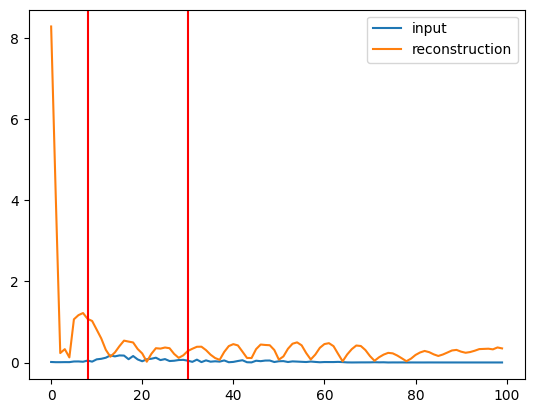

val loss=0.2270    val acc=0.6162: 100%|██████████| 210/210 [00:01<00:00, 122.40it/s]


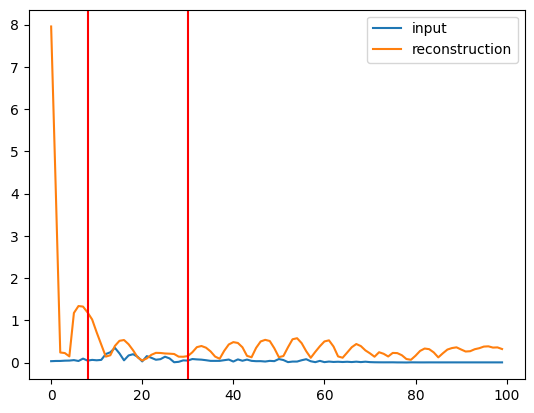

val loss=0.2209    val acc=0.6521: 100%|██████████| 210/210 [00:01<00:00, 116.12it/s]


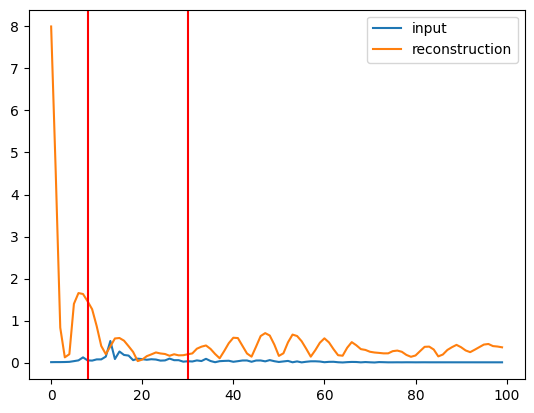

val loss=0.2071    val acc=0.6621: 100%|██████████| 210/210 [00:01<00:00, 122.35it/s]


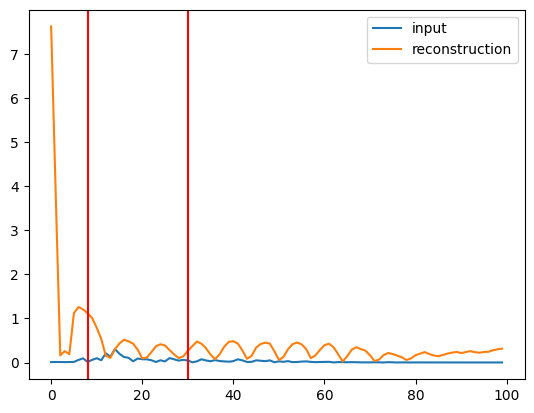

val loss=0.2070    val acc=0.6780: 100%|██████████| 210/210 [00:01<00:00, 122.15it/s]


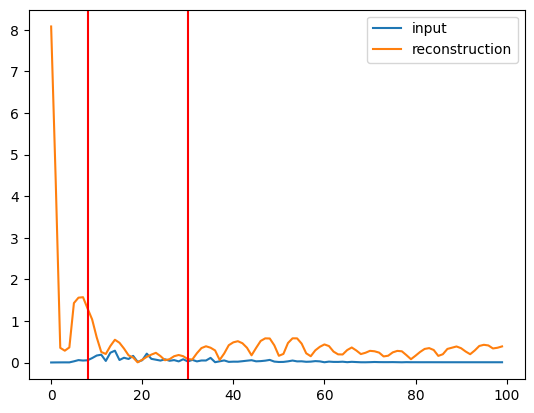

val loss=0.2254    val acc=0.6424: 100%|██████████| 210/210 [00:01<00:00, 122.34it/s]


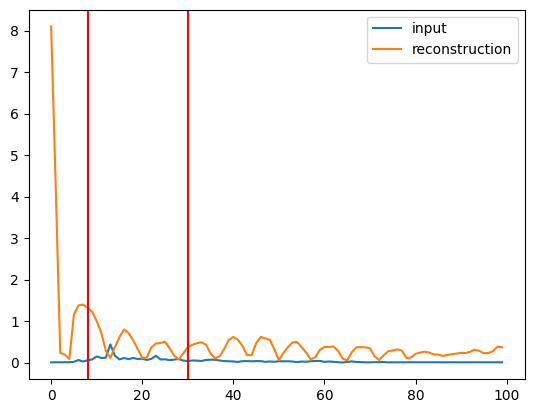

val loss=0.2489    val acc=0.5912: 100%|██████████| 210/210 [00:01<00:00, 114.83it/s]


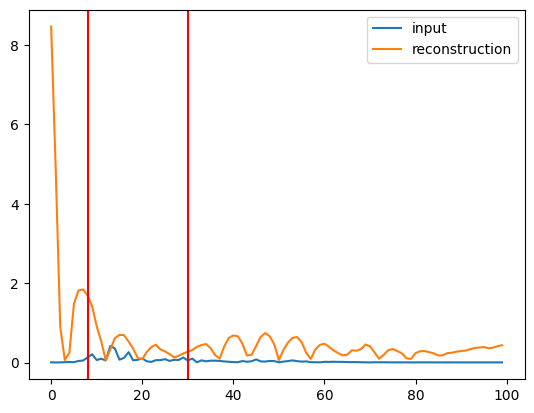

val loss=0.1754    val acc=0.7503: 100%|██████████| 210/210 [00:01<00:00, 123.41it/s]


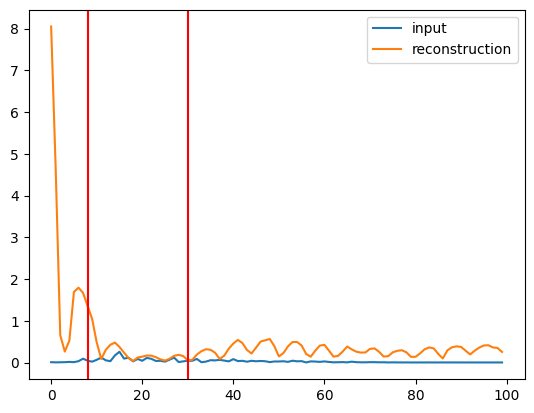

val loss=0.1976    val acc=0.6990: 100%|██████████| 210/210 [00:01<00:00, 122.51it/s]


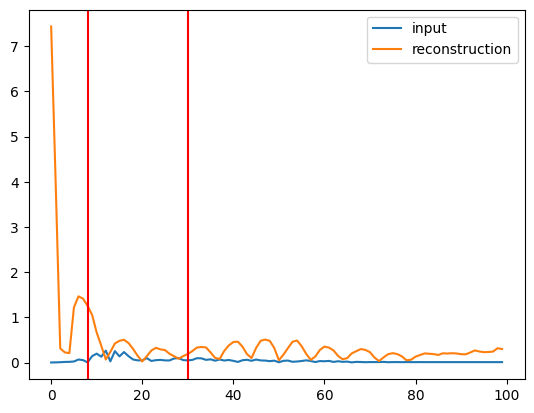

val loss=0.1855    val acc=0.7080: 100%|██████████| 210/210 [00:01<00:00, 122.55it/s]


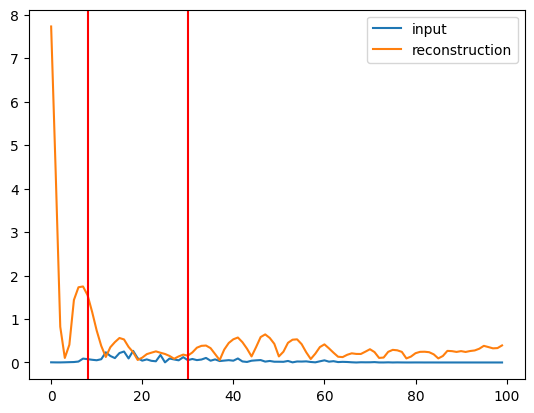

val loss=0.1802    val acc=0.7238: 100%|██████████| 210/210 [00:01<00:00, 119.38it/s]


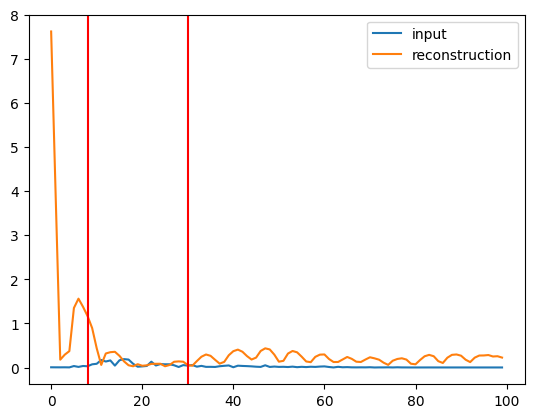

val loss=0.1794    val acc=0.7283: 100%|██████████| 210/210 [00:01<00:00, 115.88it/s]


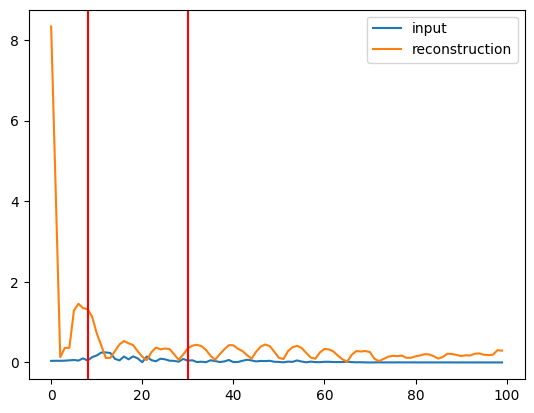

val loss=0.1859    val acc=0.7048: 100%|██████████| 210/210 [00:01<00:00, 120.11it/s]


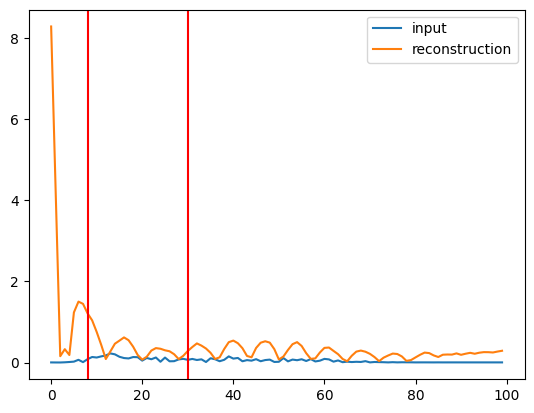

val loss=0.1804    val acc=0.7348: 100%|██████████| 210/210 [00:01<00:00, 121.25it/s]


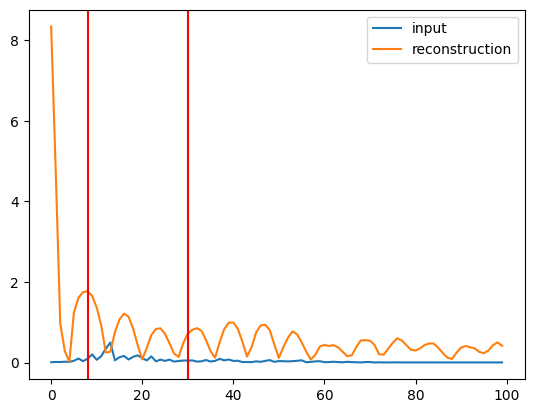

val loss=0.1803    val acc=0.7262: 100%|██████████| 210/210 [00:01<00:00, 120.56it/s]


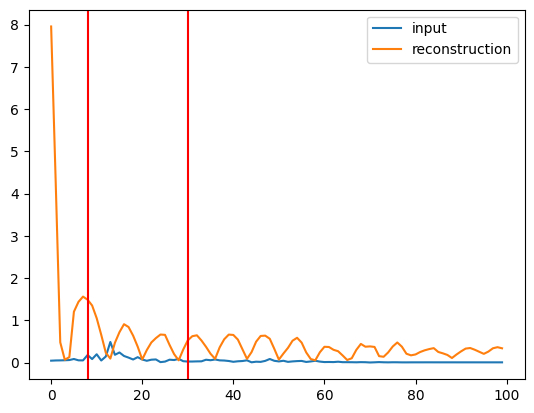

val loss=0.2074    val acc=0.6549: 100%|██████████| 210/210 [00:01<00:00, 120.08it/s]


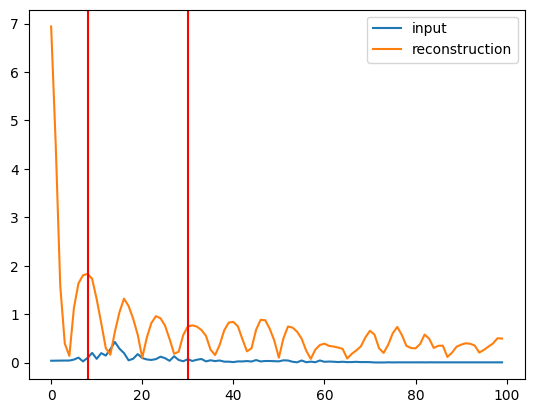

val loss=0.1744    val acc=0.7384: 100%|██████████| 210/210 [00:01<00:00, 119.90it/s]


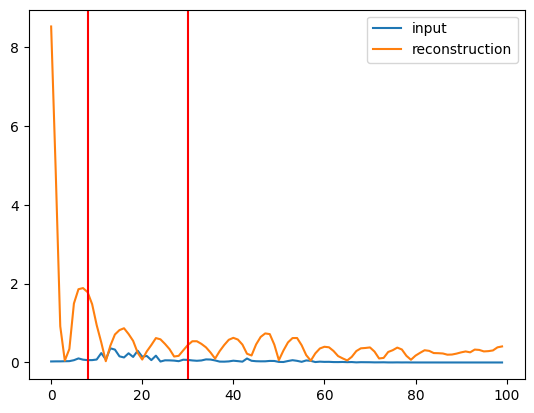

val loss=0.2037    val acc=0.6698: 100%|██████████| 210/210 [00:01<00:00, 118.47it/s]


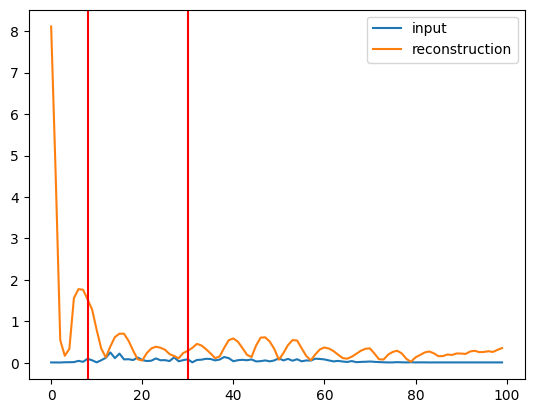

val loss=0.1909    val acc=0.6949: 100%|██████████| 210/210 [00:01<00:00, 120.16it/s]


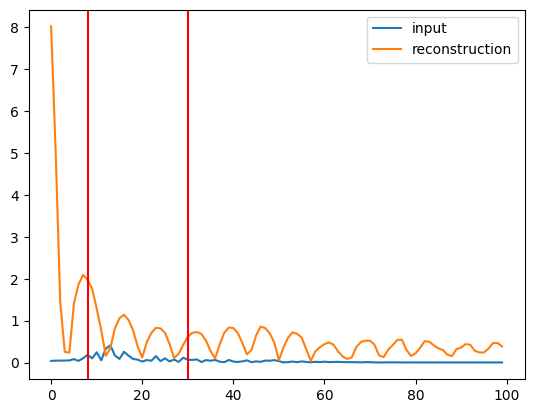

val loss=0.1933    val acc=0.6954: 100%|██████████| 210/210 [00:01<00:00, 120.42it/s]


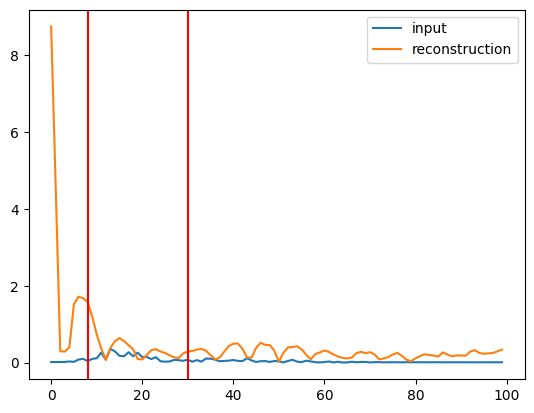

val loss=0.2151    val acc=0.6734: 100%|██████████| 210/210 [00:01<00:00, 120.96it/s]


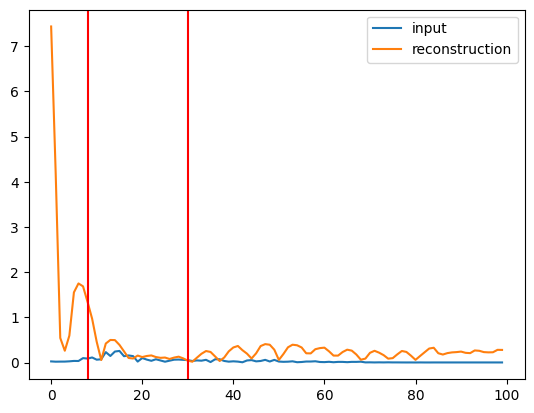

val loss=0.1818    val acc=0.7147: 100%|██████████| 210/210 [00:01<00:00, 120.68it/s]


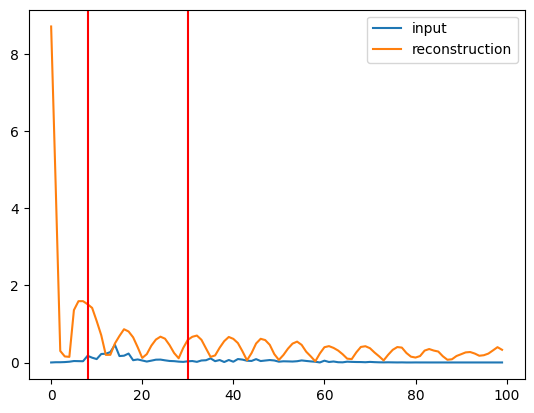

val loss=0.2127    val acc=0.6530: 100%|██████████| 210/210 [00:01<00:00, 120.61it/s]


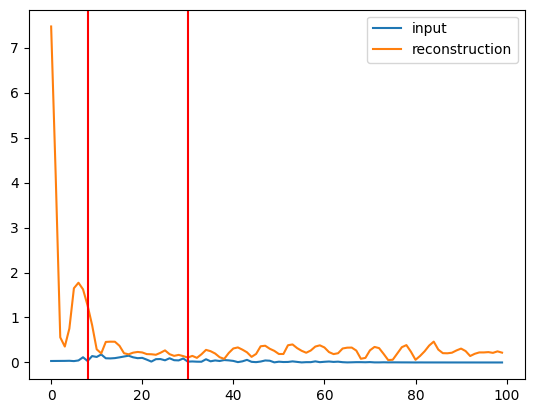

val loss=0.2035    val acc=0.6647: 100%|██████████| 210/210 [00:01<00:00, 120.77it/s]


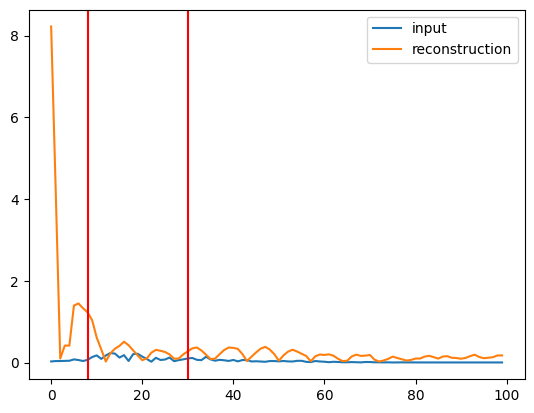

val loss=0.1953    val acc=0.6905: 100%|██████████| 210/210 [00:01<00:00, 120.68it/s]


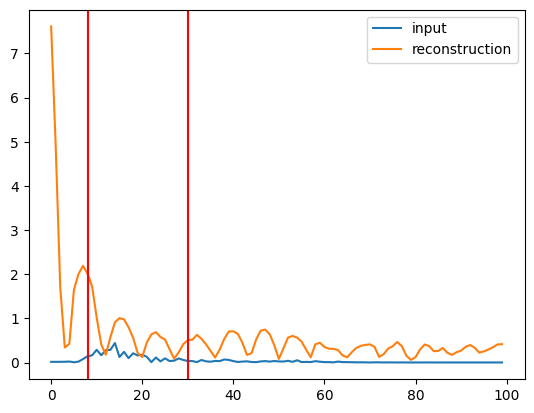

val loss=0.2091    val acc=0.6574: 100%|██████████| 210/210 [00:01<00:00, 120.41it/s]


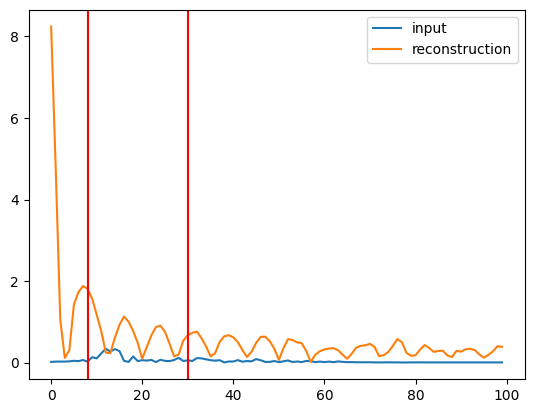



TRAIN: [ 9 10 12 13 15 16 17 19 20 22 23 24 25 27 29 30 33 35 36 37 38 39 40 42
 43 44 45 46 47 48 49 50 51 52 53 54 56 57] TEST: [55]
[55]


/tmp/ipykernel_1701368/3986792437.py:33: RuntimeWarning: invalid value encountered in divide
  filtered_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling


EEGMouse_Nathan_1_47_1173.npy
EEGMouse_Nathan_1_50_1240.npy
EEGMouse_Nathan_1_51_1262.npy
Creating augmented data
Data created


val loss=0.2426    val acc=0.5011: 100%|██████████| 212/212 [00:01<00:00, 119.60it/s]


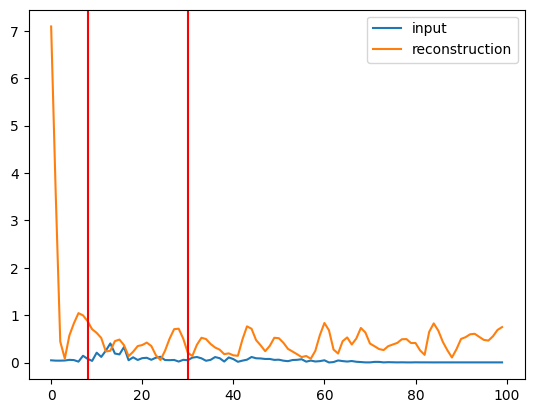

val loss=0.1666    val acc=0.8178: 100%|██████████| 212/212 [00:01<00:00, 120.53it/s]


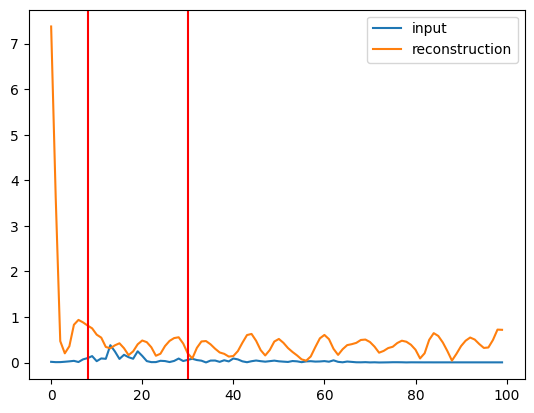

Epoch 3    loss=0.2255:  50%|█████     | 126/250 [00:04<00:04, 27.94it/s]

KeyboardInterrupt: 

In [ ]:
# do n-fold cross validation
from sklearn.model_selection import KFold
session_info = []
sorted_sessions = np.array(sorted_sessions)
# clear all tqdm bars


kfold = KFold(n_splits=len(sorted_sessions), shuffle=True, random_state=42)
test_sessions = []
val_sessions = []
train_sessions = []
for train_index, test_index in kfold.split(sorted_sessions):
  train_sessions, val_sessions = sorted_sessions[train_index], sorted_sessions[test_index]
  print("TRAIN:", train_sessions, "TEST:", val_sessions)

  train_eeg = []
  train_labels = []
  valid_eeg = []
  valid_labels = []
  test_eeg = []
  test_labels = []
  print(val_sessions)
  for i in range(len(files)):
    name = files[i]
    details = name.rstrip('.npy').split('_')[2:] # getting session details from file name
    sig = np.load(paths[i]) # loading signal 
    sig = sig[:, 1:] # removing first time step because it is inaccurate
    if sig.shape[1] == 0 or int(details[1]) not in sorted_sessions:
      #print(name)
      continue
    reindexed_signal = channel_rearrangment(sig, ordered_channels)
    filtered_sig = bandpass_filter(reindexed_signal, [5, 40], 125) # bandpass filter
    filtered_sig = (filtered_sig - np.mean(filtered_sig, 1, keepdims=True)) / np.std(filtered_sig, 1, keepdims=True) # standard scaling
    signals = segmentation(filtered_sig, 128, window_size = 1.5, window_shift = 0.0175) # segmentation
    if np.isnan(signals).any():
      print(name)
      continue
    labels = [int(details[0])] * len(signals)
    if int(details[1]) in test_sessions:
      print("this should not occur")
      test_eeg.extend(signals)
      test_labels.extend(labels)
    elif int(details[1]) in val_sessions:
      valid_eeg.extend(signals)
      valid_labels.extend(labels)
    else:
      train_eeg.extend(signals)
      train_labels.extend(labels)
    
  print("Creating augmented data")
  aug_signals, aug_labels = augmentation(train_eeg, train_labels, 20000)
  train_eeg.extend(aug_signals)
  train_labels.extend(aug_labels)
  '''aug_signals, aug_labels = wavelet_augmentation(train_eeg, train_labels, 10000)
  train_eeg.extend(aug_signals)
  train_labels.extend(aug_labels)'''
  print("Data created")


  train_eeg_tensor = torch.zeros((len(train_eeg), train_eeg[0].shape[0], train_eeg[0].shape[1])) # untransposed dimensions 1 and 2
  valid_eeg_tensor = torch.zeros((len(valid_eeg), valid_eeg[0].shape[0], valid_eeg[0].shape[1]))
  #test_eeg_tensor = torch.zeros((len(test_eeg), test_eeg[0].shape[0], test_eeg[0].shape[1]))
  for i in range(len(train_eeg)):
    tens = torch.from_numpy(train_eeg[i].copy()) # no longer transposing before conversion to tensor
    train_eeg_tensor[i] = tens
  for i in range(len(valid_eeg)):
    tens = torch.from_numpy(valid_eeg[i].copy())
    valid_eeg_tensor[i] = tens
  '''for i in range(len(test_eeg)):S
    tens = torch.from_numpy(test_eeg[i].copy())
    test_eeg_tensor[i] = tens'''
  train_label_tensor = torch.zeros(len(train_labels), 2)
  valid_label_tensor = torch.zeros(len(valid_labels), 2)
  test_label_tensor = torch.zeros(len(test_labels), 2)
  class_to_idx = {1:0, 3:1}
  for i in range(len(train_labels)):
    label = class_to_idx[train_labels[i]]
    train_label_tensor[i][label] = 1
  for i in range(len(valid_labels)):
    label = class_to_idx[valid_labels[i]]
    valid_label_tensor[i][label] = 1
  for i in range(len(test_labels)):
    label = class_to_idx[test_labels[i]]
    test_label_tensor[i][label] = 1

  train_ds = TData(train_eeg_tensor, train_label_tensor)
  valid_ds = TData(valid_eeg_tensor, valid_label_tensor)
  #test_ds = TData(test_eeg_tensor, test_label_tensor)
  train_dl = DL(train_ds, batch_size=32, shuffle= True, drop_last = True, pin_memory=True)
  valid_dl = DL(valid_ds, batch_size=32, shuffle= True, pin_memory=True)
  #test_dl = DL(test_ds, batch_size=32, shuffle = True, drop_last = True)
  train_dl = LimitedDataLoader(train_dl, 250)
  device = 'cuda'
  lin = FusionLinear(16, 2).to(device)
  info = train_caps(train_dl, valid_dl, val_sessions[0])
  session_info.append(info)
  print()
  print("=====================================================================================================")
  print()

    

In [ ]:
import json

# load in the json file 
with open('max_accs_new_aug.json') as f:
    prev_accs = json.load(f)

In [ ]:
max_accs = []
for i in range(len(session_info)):
    print(f"Session {session_info[i]['index']}    max accuracy: {max(session_info[i]['val accs']):.4f}")
    max_accs.append({'session': session_info[i]['index'], 'max_acc': max(session_info[i]['val accs'])})

In [ ]:
# get average max accuracy
avg_max = sum([x['max_acc'] for x in max_accs]) / len(max_accs)
avg_max_aug = sum([prev_accs[key] for key in prev_accs]) / len(prev_accs)
avg_max, avg_max_aug

In [ ]:
# sort by max_acc
max_accs = sorted(max_accs, key = lambda x: x['max_acc'], reverse = True)
max_accs_dict = {}
for i in range(len(max_accs)):
    max_accs_dict[int(max_accs[i]['session'][0])] = max_accs[i]['max_acc']
    print(f"Session {max_accs[i]['session']}    max accuracy: {max_accs[i]['max_acc']:.4f}")

In [ ]:
import matplotlib.pyplot as plt

plt.bar(max_accs_dict.keys(), max_accs_dict.values(), alpha = 0.5)
plt.bar(max_accs_dict.keys(), [prev_accs[str(key)] for key in max_accs_dict.keys() if str(key) in prev_accs], alpha = 0.5)
plt.xlabel('Session')
plt.ylabel('Max accuracy')
plt.title('Max accuracy of each session')
plt.legend(['w/ augmentation', 'w/o augmentation'])
plt.show()
# print average accuracy of new model
print(f"Average accuracy w/ augmentation: {np.mean(list(max_accs_dict.values())):.4f}")
# print average accuracy of old model given the sessions in the new model
print(f"Average accuracy w/o augmentation: {np.mean(list(prev_accs.values())):.4f}")

In [ ]:
with open('max_accs_new_aug_3.json', 'w') as f:
    json.dump(max_accs_dict, f)